# 1. Python的内存管理机制
- 引用计数
- 垃圾回收
- 内存池

## 1.1 引用计数
它是一种非常高效的内存管理手段，当一个Python对象被引用时，其引用计数增加1；当其不再被引用时，引用计数减1，当引用计数等于0时，对象就被删除了。

## 2. 垃圾回收
### 2.1、什么是垃圾回收机制
垃圾回收机制(简称GC)是Python解释器自带的一种机制，是专门用来回收不可用的变量所占用的内存空间

### 2.2、引用计数
引用计数也是一种垃圾回收机制，而且是一种最直观，最简单的垃圾回收技术。

Python中每一个对象的核心就是一个结构体PyObject，内部有一个引用计数ob_refcnt,当python对象引用计数为0，就说明没有任何引用指向该对象，该对象就成为要被回收的垃圾了。

示例：当一个对象被创建出来，它的引用计数就会加1，当对象被引用的时候，计数继续增加；当引用它的对象被删除的时候，它的引用计数就会减少，直到变为0，此时垃圾回收机制就会将其回收。如果出现循环引用，就需要采用别的办法了。

```
In [1]: a = [1, 2]

In [2]: import sys

In [3]: sys.getrefcount(a)  # 获取对象a的引用次数
Out[3]: 2

In [4]: b = a

In [5]: sys.getrefcount(a)
Out[5]: 3

In [6]: del b # 删除b的引用

In [7]: sys.getrefcount(a)
Out[7]: 2

In [8]: c = list()

In [9]: c.append(a) # 加入到容器中

In [10]: sys.getrefcount(a)
Out[10]: 3

In [11]: del c  # 删除容器，引用-1

In [12]: sys.getrefcount(a)
Out[12]: 2

In [13]: b = a

In [14]: sys.getrefcount(a)
Out[14]: 3

In [15]: a = [3, 4] # 重新赋值

In [16]: sys.getrefcount(a)
Out[16]: 2
```
> 注意：当把a作为参数传递给getrefcount时，会产生一个临时的引用，因此的出来的结果比真实情况+1

**引用计数增加的情况**：
- 一个对象被分配给一个新的名字（例如：a=\[1,2\]）
- 将其放入一个容器中（如列表、元组或字典）（例如：c.append(a)）

**引用计数减少的情况**：
- 使用`del`语句对对象别名显式的销毁（例如：del b）
- 对象所在的容器被销毁或从容器中删除对象（例如：del c）
- 引用超出作用域或被重新赋值（例如：a=\[3,4\]）

**注意**：当两个对象互相引用的时候，del语句可以减少引用次数，但是引用计数不会归0，对象就不会被销毁，从而造成内存泄漏问题

### 2.3 标记清除
**标记清除**是用来解决循环引用产生的问题，循环引用只有在容器对象才会产生，比如字典、元组、列表等。先按需分配，等到没有空闲内存的时候，从寄存器和程序栈上的引用出发，遍历所有对象和引用把所有能访问的打标记，最后将没有标记的对象释放。

标记清除机制在进行垃圾回收时分成了两步
- 标记阶段，遍历所有的对象，如果时可达的(reachable)，也就是还有对象引用它，那么就标记该对象为可达。
- 清除阶段，再次遍历对象，如果发现某个对象没有标记为可达(Unreachable)，则就将其回收

```
In [1]: a = [1, 2]

In [2]: b = [3, 4]

In [3]: import sys

In [4]: sys.getrefcount(a)
Out[4]: 2
 
In [5]: sys.getrefcount(b)
Out[5]: 2

In [6]: a.append(b)

In [7]: sys.getrefcount(b)
Out[7]: 3

In [8]: b.append(a)

In [9]: sys.getrefcount(a)
Out[9]: 3

In [10]: del a

In [11]: sys.getrefcount(a)
---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
<ipython-input-11-d536ea93c9cb> in <module>
----> 1 sys.getrefcount(a)

NameError: name 'a' is not defined

In [12]: del b

In [13]: sys.getrefcount(b)
---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
<ipython-input-13-e0d8d1240a7d> in <module>
----> 1 sys.getrefcount(b)

NameError: name 'b' is not defined
```
- a引用b，b引用a，此时两个对象各自被引用了2次(去除getrefcount()的临时引用）

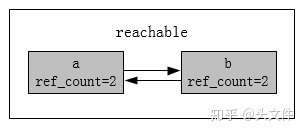

- 执行del之后，对象a，b的引用次数都-1，此时各自的引用计数器都为1，陷入循环引入

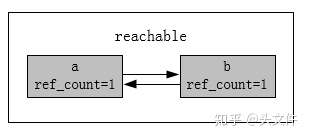

- 标记：找到其中的一端a，因为它有一个对b的引用，则将b的引用计数-1

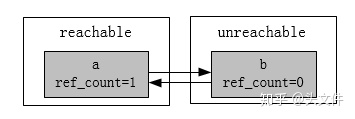

- 标记：在沿着引用到b，b有一个a的引用，将a的引用计数-1，此时对象a和b的引用次数全部为0，被标记为不可达（Unreachable）

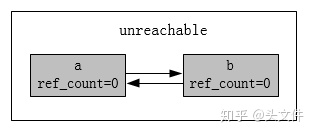

- 清除：被标记为不可达的对象就是真正需要被释放的对象

> 上面描述的垃圾回收的阶段，会暂停整个应用程序，等待标记清除结束后才会恢复应用程序的运行。为了减少应用程序暂停的时间，Python通过“分代回收”(Generational Collection)以空间换时间的方法提高垃圾回收效率。


### 2.4 分代回收
> 分代回收是基于这样的一个统计事实，对于程序，存在一定比例的内存块的生存周期比较短；而剩下的内存块，生存周期会比较长，甚至会从程序开始一直持续到程序结束。因此，简单的认为：对象存在时间越长，越可能不是垃圾，应该越少去收集。这样在标记-清除算法时可以有效的减小遍历的对象数，从而提高垃圾回收的速度，**是一种以空间换时间的方法策略**。

Python将所有的对象分为年轻代(第0代)、中年代(第1代)、老年代(第2代)三代。所有的新建对象默认是第0代对象。当在第0代的gc扫描中存货下来的对象将被移至第1代，在第1代的gc扫描中存货下来的对象将被移至第2代。

> gc扫描次数（第0代>第1代>第2代）

当某一代中被分配的对象与被释放的对象之差达到某一阈值时，就会触发当前一代的gc扫描。当某一代被扫描时，比它年轻的一代也会被扫描，因此，第2代的gc扫描发生时，第0，1代的gc扫描也会发生，即为全代扫描。

```
In [1]: import gc

In [2]: gc.get_threshold()  # 分代回收机制的参数阈值设置
Out[2]: (700, 10, 10)
```

- 700=新分配的对象数量-释放的对象数量，第0代gc扫描被触发
- 第一个10：第0代gc扫描发生10次，则第1代的gc扫描被触发
- 第二个10：第1代gc扫描发生10次，则第2代的gc扫描被触发



## 3. 内存池
- Python的内存机制呈现金字塔形状
- 第-1，-2层：操作系统进行操作
- 第0层：大内存-请求分配的内存大于256k，C中的malloc，free等内存分配和释放函数进行操作
- 第1层和第2层：内存池，有python接口函数，PyMem_Malloc函数实现，当对象小于256K时就是用内存池管理系统进行分配，调用malloc函数分配内存，但是每次只会分配一块大小为256K的大块内存，不会调用free函数释放内存，将该内存块留在内存池中以便下次使用。
- 第3层：最上面，用户对python对象的直接操作。

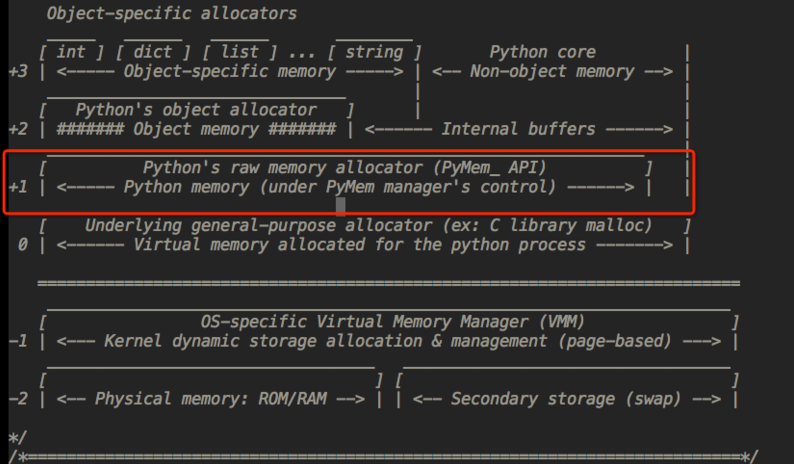